# 利用Python对链家网北京主城区二手房进行数据分析
* 本文主要讲述如何通过pandas对爬虫下来的链家数据进行相应的二手房数据分析，主要分析内容包括各个行政区，各个小区的房源信息情况。
* 数据来源 https://github.com/XuefengHuang/lianjia-scrawler 该repo提供了python程序进行链家网爬虫，并从中提取二手房价格、面积、户型和二手房关注度等数据。
* 分析方法参考 http://www.jianshu.com/p/44f261a62c0f

## 导入链家网二手房在售房源的文件（数据更新时间2017-11-29）

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import sys

stdout = sys.stdout

import importlib
importlib.reload(sys)

#reload(sys)
#sys.setdefaultencoding('utf-8')
sys.stdout = stdout

plt.rcParams['font.sans-serif'] = ['SimHei']    
plt.rcParams['axes.unicode_minus'] = False

#所有在售房源信息
house=pd.read_csv('rentinfo.csv')

# 所有小区信息
community=pd.read_csv('community.csv')

# 合并小区信息和房源信息表，可以获得房源更详细的地理位置
community['community'] = community['title']
house_detail = pd.merge(house, community, left_on='region', right_on='community')

## 将数据从字符串提取出来

In [6]:
# 将字符串转换成数字
def data_adj(area_data, str):       
    if str in area_data :        
        return float(area_data[0 : area_data.find(str)])    
    else :        
        return None
# 处理房屋面积数据
house['meters'] = house['meters'].apply(data_adj,str = '平米')

## 删除车位信息

In [8]:
car=house[house.housetype.str.contains('车位')]
print ('记录中共有车位%d个'%car.shape[0])
house.drop(car.index,inplace=True)
print ('现在还剩下%d条记录'%house.shape[0])

AttributeError: 'DataFrame' object has no attribute 'housetype'

## 价格最高的5个别墅

In [9]:
bieshu=house[house.housetype.str.contains('别墅')]
print ('记录中共有别墅%d栋'%bieshu.shape[0])
bieshu.sort_values('totalPrice',ascending=False).head(5)

AttributeError: 'DataFrame' object has no attribute 'housetype'

## 删除别墅信息

In [10]:
house.drop(bieshu.index,inplace=True)
print ('现在还剩下%d条记录'%house.shape[0])

NameError: name 'bieshu' is not defined

## 获取总价前五的房源信息

In [13]:
house.sort_values('price',ascending=False).head(5)

,houseID,title,link,region,zone,meters,other,subway,decoration,heating,price,pricepre,updatedate
3554,BJ0004294598,富力十号5居室,https://bj.lianjia.com/zufang/BJ0004294598.html,富力十号,5室2厅,445.0,双井租房/低楼层(共3层)/2012年建,距离7号线广渠门外站776米,原味,集中供暖,250000,2018.06.07 更新,2018-06-09 00:15:50
307,101102652296,富力十号别墅，精装修自住的，未出租过，看房方便,https://bj.lianjia.com/zufang/101102652296.html,富力十号,5室2厅,490.0,双井租房/低楼层(共3层)/2012年建,距离7号线广渠门外站757米,精装修,集中供暖,250000,2018.06.08 更新,2018-06-09 00:16:11
525,101102756055,三环内的别墅 空房出租 可做会所 诚意出租 看房随时,https://bj.lianjia.com/zufang/101102756055.html,富力十号,5室2厅,444.0,双井租房/低楼层(共3层)/2012年建,距离7号线广渠门外站776米,精装修,集中供暖,220000,2018.06.02 更新,2018-06-09 12:26:50
0,101092239300,棕榈泉国际公寓 南北通透顶层复式 精装修,https://bj.lianjia.com/zufang/101092239300.html,棕榈泉国际公寓,5室3厅,316.0,朝阳公园租房/高楼层(共30层)/2003年建板塔结合,距离14号线(东段)朝阳公园站196米,精装修,集中供暖,150000,2018.05.30 更新,2018-06-09 12:27:36
555,101102765077,亚运新新家园润雪园四期联排别墅，精装修,https://bj.lianjia.com/zufang/101102765077.html,亚运新新家园润雪园四期,5室2厅,549.0,亚运村小营租房/低楼层(共3层)/2011年建,NaN,精装修,集中供暖,150000,2018.05.29 更新,2018-06-09 12:27:46


## 获取户型数量分布信息

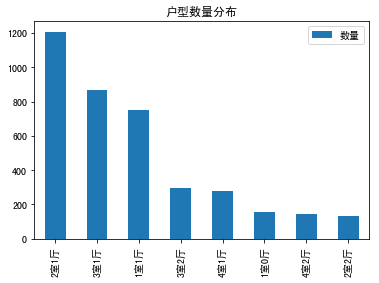

In [15]:
housetype = house['zone'].value_counts()
housetype.head(8).plot(kind='bar',x='zone',y='size', title='户型数量分布')
plt.legend(['数量']) 
plt.show()

## 关注人数最多5套房子

In [10]:
house['guanzhu'] = house['followInfo'].apply(data_adj,str = '人关注')
house.sort_values('guanzhu',ascending=False).head(5)

,houseID,title,link,community,years,housetype,square,direction,floor,taxtype,totalPrice,unitPrice,followInfo,decoration,validdate,guanzhu
0,101101687525,安慧里五区 南北通透两居室 户型方正 中楼层,https://bj.lianjia.com/ershoufang/101101687525...,安慧里五区,低楼层(共12层)/1998年建板楼/亚运村,3室1厅,84.30,南 北,低楼层(共12层)/1998年建板楼/亚运村,房本满五年,555,65837,530人关注/14次带看11个月以前发布距离5号线惠新西街北口站713米房本满五年随时看房5...,简装,2018-06-09 12:21:46,530.0
3,101102511992,满五年 南北向 精装修 小三居 居住舒适,https://bj.lianjia.com/ershoufang/101102511992...,安慧里三区,底层(共20层)/1990年建塔楼/亚运村,3室1厅,70.78,南 北,底层(共20层)/1990年建塔楼/亚运村,房本满五年,510,72055,261人关注/7次带看4个月以前发布房本满五年510万单价72055元/平米,精装,2018-06-09 12:22:10,261.0
2,101102376226,安慧里板楼高层2居 南北通透 满五年,https://bj.lianjia.com/ershoufang/101102376226...,安慧里一区,高楼层(共18层)/1990年建板楼/亚运村,2室1厅,63.28,南 北,高楼层(共18层)/1990年建板楼/亚运村,房本满五年,495,78224,139人关注/5次带看5个月以前发布距离5号线大屯路东站1123米房本满五年495万单价78...,简装,2018-06-09 12:22:01,139.0
4,101102561863,满五唯一 东南两居 双卧朝南 精装修,https://bj.lianjia.com/ershoufang/101102561863...,安慧里一区,低楼层(共25层)/1990年建塔楼/亚运村,2室2厅,66.33,东南,低楼层(共25层)/1990年建塔楼/亚运村,房本满五年,568,85633,116人关注/35次带看3个月以前发布距离5号线惠新西街北口站1164米房本满五年568万单...,精装,2018-06-09 12:21:02,116.0
6,101102699512,安慧里南北通透，满五年唯一，独门独院管理,https://bj.lianjia.com/ershoufang/101102699512...,安慧里五区,中楼层(共6层)/1991年建板楼/亚运村,2室1厅,57.90,南 北,中楼层(共6层)/1991年建板楼/亚运村,房本满五年,430,74266,109人关注/20次带看2个月以前发布距离5号线惠新西街北口站523米房本满五年430万单价...,精装,2018-06-09 12:22:38,109.0


## 户型和关注人数分布

In [11]:
fig, ax1 = plt.subplots(1,1)    
type_interest_group = house['guanzhu'].groupby(house['housetype']).agg([('户型', 'count'), ('关注人数', 'sum')])    
#取户型>50的数据进行可视化
ti_sort = type_interest_group[type_interest_group['户型'] > 50].sort_values(by='户型')    
ti_sort.plot(kind='barh', alpha=0.7, grid=True, ax=ax1)    
plt.title('二手房户型和关注人数分布')    
plt.ylabel('户型') 
plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot

## 面积分布

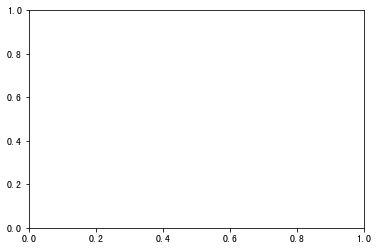

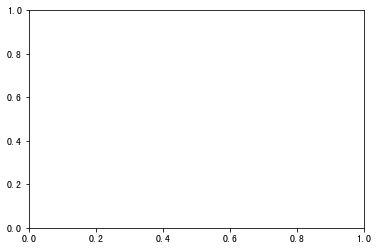

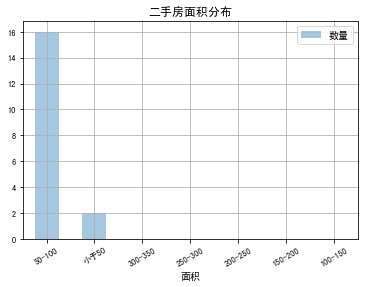

In [12]:
fig,ax2 = plt.subplots(1,1)    
area_level = [0, 50, 100, 150, 200, 250, 300, 500]    
label_level = ['小于50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350']    
area_cut = pd.cut(house['square'], area_level, labels=label_level)        
area_cut.value_counts().plot(kind='bar', rot=30, alpha=0.4, grid=True, fontsize='small', ax=ax2)    
plt.title('二手房面积分布')    
plt.xlabel('面积')    
plt.legend(['数量'])    
plt.show()

## 聚类分析

In [13]:
# 缺失值处理:直接将缺失值去掉    
cluster_data = house[['guanzhu','square','totalPrice']].dropna()    
#将簇数设为3    
K_model = KMeans(n_clusters=3)    
alg = K_model.fit(cluster_data)    
'------聚类中心------'   
center = pd.DataFrame(alg.cluster_centers_, columns=['关注人数','面积','房价'])    
cluster_data['label'] = alg.labels_ 
center

,关注人数,面积,房价
0,395.500000,77.540000,532.500000
1,67.666667,53.136667,419.222222
2,40.857143,73.165714,575.714286


## 北京市在售面积最小二手房

In [14]:
house.sort_values('square').iloc[0,:]

houseID                                            101102840781
title                                     安慧里五区 东向一居室 诚心出售 随时签约
link          https://bj.lianjia.com/ershoufang/101102840781...
community                                                安慧里五区 
years                                    低楼层(共12层)/1998年建板楼/亚运村
housetype                                                  1室1厅
square                                                     41.4
direction                                                     东
floor                                    低楼层(共12层)/1998年建板楼/亚运村
taxtype                                                   房本满五年
totalPrice                                                  310
unitPrice                                                 74880
followInfo    44人关注/13次带看1个月以前发布距离5号线惠新西街北口站713米房本满五年310万单价7...
decoration                                                   简装
validdate                                   2018-06-09 12:23:06
guanzhu                                 

## 北京市在售面积最大二手房

In [15]:
house.sort_values('square',ascending=False).iloc[0,:]

houseID                                            101102918100
title                                        安慧里小区中间 全明格局 满五年唯一
link          https://bj.lianjia.com/ershoufang/101102918100...
community                                                安慧里二区 
years                                    高楼层(共25层)/1990年建塔楼/亚运村
housetype                                                  3室1厅
square                                                    85.27
direction                                              东南 西北 东北
floor                                    高楼层(共25层)/1990年建塔楼/亚运村
taxtype                                                   房本满五年
totalPrice                                                  645
unitPrice                                                 75643
followInfo                14人关注/2次带看12天以前发布房本满五年645万单价75643元/平米
decoration                                                   简装
validdate                                   2018-06-09 12:22:01
guanzhu                                 

## 各个行政区房源均价

In [16]:
house_unitprice_perdistrict = house_detail.groupby('district').mean()['unitPrice']
house_unitprice_perdistrict.plot(kind='bar',x='district',y='unitPrice', title='各个行政区房源均价')
plt.legend(['均价']) 
plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot

## 各个区域房源数量排序

In [17]:
bizcircle_count=house_detail.groupby('bizcircle').size().sort_values(ascending=False)
bizcircle_count.head(20).plot(kind='bar',x='bizcircle',y='size', title='各个区域房源数量分布')
plt.legend(['数量']) 
plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot

## 各个区域均价排序

In [18]:
bizcircle_unitprice=house_detail.groupby('bizcircle').mean()['unitPrice'].sort_values(ascending=False)
bizcircle_unitprice.head(20).plot(kind='bar',x='bizcircle',y='unitPrice', title='各个区域均价分布')
plt.legend(['均价']) 
plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot

## 各个区域小区数量

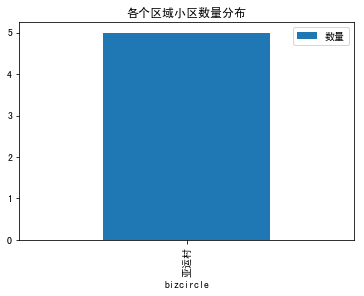

In [19]:
bizcircle_community=community.groupby('bizcircle')['title'].size().sort_values(ascending=False)
bizcircle_community.head(20).plot(kind='bar', x='bizcircle',y='size', title='各个区域小区数量分布')
plt.legend(['数量']) 
plt.show()

## 按小区均价排序

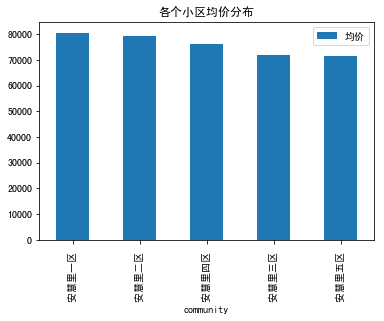

In [20]:
community_unitprice = house.groupby('community').mean()['unitPrice'].sort_values(ascending=False)
community_unitprice.head(15).plot(kind='bar',x='community',y='unitPrice', title='各个小区均价分布')
plt.legend(['均价']) 
plt.show()